In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import itertools

plt.rcParams['font.size'] = 14

# Training  
In the training part we define the python class `boltzmanmachine`, the data selection, and the network parameters.The boltzman machine has been trained with temperatures that range from 0.05 to 0.5. The weights and bias obtained by the training algorithm are stored in `.npz` files to easily access them in the fantasy particles generation algorithm. As a consistency check we introduced the LogLikelihood method.

## Boltzmann machine class 

In [21]:
class boltzmanmachine:
    
    def __init__(self, L, M, sigma, De=2, vmin=-1, spin=True):
        '''
        Initialize the object with defaults parameter which are determined by
        meta reciew.
        w: network weights
        a: visible bias
        b: hidden bias
        spin: set the notation used by the model, (0,1) or (-1,1)
        DE: energy separation among the two possible states allowed in the positive phases, 1 or 2
        vmin: minimum value of the representation
        '''
        self.w = np.random.normal(loc=0.0, scale=sigma, size=(L,M))
        self.a = np.random.normal(loc=0.0, scale=sigma, size=L)
        self.b = b = np.zeros(M)
        
        self.spin=spin
        
        self.DE = De
        self.L = int(L)
        self.M = int(M)
        self.vmin=vmin
        
        self.v_data, self.v_model = None, None
        self.h_data, self.h_model = None, None
        self.vh_data,self.vh_model= None, None
        
        #one hot encoding of the four possible states
        if self.spin:
            self.csi1 = np.array([1,-1,-1,-1])    
            self.csi2 = np.array([-1,1,-1,-1])   
            self.csi3 = np.array([-1,-1,1,-1])    
            self.csi4 = np.array([-1,-1,-1,1])  
        else:
            self.csi1 = np.array([1,0,0,0])    
            self.csi2 = np.array([0,1,0,0])   
            self.csi3 = np.array([0,0,1,0])    
            self.csi4 = np.array([0,0,0,1]) 
            
        self.csi = [self.csi1, self.csi2, self.csi3, self.csi4]
        
        #algotithm variables
        self.sa_t0 = 0
        self.sb_t0 = 0
        self.sw_t0 = 0
        
        self.ma_t0 = 0
        self.mb_t0 = 0
        self.mw_t0 = 0
        
        self.batch_counter = 0
        
    def load_model(self, file_name):
        model = np.load(file_name)
        
        self.w = model['w']
        self.a = model['a']
        self.b = model['b']
        
        
        
    def save_model(self, file_name):
        np.savez(file_name, a=self.a, b=self.b, w=self.w)
        
        
        
    def init_avg(self):
        '''
        Set  to zero the averages quantities needed to compute the gradien
        '''
        self.v_data, self.v_model = np.zeros(self.L),np.zeros(self.L)
        self.h_data, self.h_model = np.zeros(self.M),np.zeros(self.M)
        self.vh_data,self.vh_model= np.zeros((self.L,self.M)),np.zeros((self.L,self.M))
        
        
        
    def positive(self, v_in, Amp=1.):
        '''
        Positive phase of the training
        Visible -> Hidden
        No one-hot encoding needed
        '''
        act = np.dot(v_in, self.w) + self.b      
        #print(act)
        argument=np.exp(-Amp*self.DE*act)
        prob = 1. / (1. + argument)
        n = np.shape(act)
        h = np.full(n, self.vmin, dtype=int) # a list on -1's or 0's
        h[np.random.random_sample(n) < prob] = 1
        
        return h
    
    def neg(self, h_in, Amp=1.):
        '''
        Negative phase of the training
        Hidden -> Visible
        No one-hot encoding needed
        '''
        act = np.dot(h_in, self.w.T) + self.a      
        #print(act)
        prob = 1. / (1. + np.exp(-Amp*self.DE*act))
        n = np.shape(act)
        vf = np.full(n, self.vmin, dtype=int) # a list on -1's or 0's
        vf[np.random.random_sample(n) < prob] = 1
        
        return vf
    
    
    def negative(self, h_in, Amp=1.):
        '''
        Negative phase of the training
        Hidden -> Visible
        With ne-hot encoding needed
        '''
        
        weigths = np.reshape(np.dot(h_in, self.w.T) + self.a, (5,4) ) 

        
        E1 = np.dot(weigths, self.csi1) #array of length 5, the number of amminoacids
        E2 = np.dot(weigths, self.csi2)
        E3 = np.dot(weigths, self.csi3)
        E4 = np.dot(weigths, self.csi4)
        


        Z = np.exp(-Amp*E1) + np.exp(-Amp*E2) + np.exp(-Amp*E3) + np.exp(-Amp*E4) #partition function for each amminoacid
        
        p1 = np.exp(-Amp*E1)/Z 
        p2 = np.exp(-Amp*E2)/Z
        p3 = np.exp(-Amp*E3)/Z
        p4 = np.exp(-Amp*E4)/Z
        
        
        
        p = np.reshape(np.concatenate((p1, p2, p3, p4)), (4, 5))      

        
        cum = np.cumsum(p, axis=0) #(4x5) containing the comulatives  
        r = np.random.random(size=5)        
        
        mask = cum < r    
        indx = []    
        
        for i in range(mask.shape[1]):
            __, index = np.unique(mask[:, i], return_index=True)
            indx.append(index[0])
            
        vf=np.concatenate((self.csi[indx[0]], self.csi[indx[1]], self.csi[indx[2]], self.csi[indx[3]], self.csi[indx[4]]))
        return vf
        
    
    def update_vh(self, v_k, vf, h, hf, mini):
        '''
        Update the averages needed to compute the gradient
        '''
        self.v_data  += v_k/mini
        self.v_model += vf/mini
        self.h_data  += h/mini
        self.h_model += hf/mini
        self.vh_data += np.outer(v_k.T,h)/mini
        self.vh_model+= np.outer(vf.T,hf)/mini
    
    def SGD(self, l_rate_m):
        '''
        Stochastic gradient descent algorithm
        '''
        dw = l_rate_m*(self.vh_data - self.vh_model)
        da = l_rate_m*(self.v_data - self.v_model)
        db = l_rate_m*(self.h_data - self.h_model)
        
        self.w += dw
        self.a += da
        self.b += db
        
    def RMSprop(self, eta_t, beta=0.9, epsilon=1e-8):
        '''
        RMSprop algorithm
        '''
        ga_t = self.v_data - self.v_model
        gb_t = self.h_data - self.h_model
        gw_t = self.vh_data - self.vh_model
        
        sa_t = beta*self.sa_t0 + (1-beta)*ga_t**2
        sb_t = beta*self.sb_t0 + (1-beta)*gb_t**2
        sw_t = beta*self.sw_t0 + (1-beta)*gw_t**2
        
        self.sa_t0 = sa_t
        self.sb_t0 = sb_t
        self.sw_t0 = sw_t
        
        
        self.a = self.a + eta_t*ga_t/np.sqrt(sa_t + epsilon)
        self.b = self.b + eta_t*gb_t/np.sqrt(sb_t + epsilon)
        self.w = self.w + eta_t*gw_t/np.sqrt(sw_t + epsilon)
        
        
    def ADAM(self, eta_t, epoch, beta1=0.9, beta2=0.99,epsilon=1e-8):
        '''
        ADAM algorithm
        '''
        ga_t = self.v_data - self.v_model
        gb_t = self.h_data - self.h_model
        gw_t = self.vh_data - self.vh_model

        ma_t = beta1*self.ma_t0 + (1-beta1)*ga_t
        mb_t = beta1*self.mb_t0 + (1-beta1)*gb_t
        mw_t = beta1*self.mw_t0 + (1-beta1)*gw_t

        sa_t = beta2*self.sa_t0 + (1-beta2)*ga_t**2
        sb_t = beta2*self.sb_t0 + (1-beta2)*gb_t**2
        sw_t = beta2*self.sw_t0 + (1-beta2)*gw_t**2

        self.sa_t0 = sa_t
        self.sb_t0 = sb_t
        self.sw_t0 = sw_t

        self.ma_t0 = ma_t
        self.mb_t0 = mb_t
        self.mw_t0 = mw_t

        ma_t_hat = ma_t/(1-beta1**epoch) 
        mb_t_hat = mb_t/(1-beta1**epoch) 
        mw_t_hat = mw_t/(1-beta1**epoch)

        sa_t_hat = sa_t/(1-beta2**epoch) 
        sb_t_hat = sb_t/(1-beta2**epoch) 
        sw_t_hat = sw_t/(1-beta2**epoch)

        self.a = self.a + eta_t*ma_t_hat/(np.sqrt(sa_t_hat) + epsilon)
        self.b = self.b + eta_t*mb_t_hat/(np.sqrt(sb_t_hat) + epsilon)
        self.w = self.w + eta_t*mw_t_hat/(np.sqrt(sw_t_hat) + epsilon)
        
    def train(self, data, learning_rate, batch_size, n_contrastive_div, Amp_training, Algorithm, epoch=1):
        
        if self.batch_counter == 0:
            self.init_avg()
            
        v_k = np.copy(data)
        vf = np.copy(data)
        
        for i in np.arange(n_contrastive_div):
            h = self.positive(vf, Amp_training)
            vf = self.negative(h, Amp_training)
        hf = self.positive(vf, Amp_training)
        
        self.update_vh(v_k, vf, h, hf, batch_size)
        
        self.batch_counter += 1
        
        if self.batch_counter == batch_size:
            if Algorithm == 'SGD':
                self.SGD(learning_rate)
            if Algorithm == 'RMSprop':
                self.RMSprop(learning_rate)
            if Algorithm == 'Adam':
                self.ADAM(l_rate, epoch+1)
                
            self.batch_counter = 0


    def gen_fantasy(self, data, Amp_gen):
        
        vf = np.zeros_like(data)
        N = data.shape[0]
        
        for k in range(N):
            # positive CD phase: generating h 
            h = self.positive(data[k],Amp_gen)
            # negative CD phase: generating fantasy vf with low T == large GAP
            vf[k] = self.negative(h,Amp_gen)
            
        return vf


## Data selection

In [3]:
dname="DATA_b"

fname=dname+'/x_RBM_q0.1.dat'
v = np.loadtxt(fname, delimiter=" ",dtype=int)
v0 = np.copy(v)  #Copy original data to analyse later

## Network parameters

In [4]:
N = len(v)       #Number of rows
L = len(v[0])    #Set the number of visible variable
M = 3            #Set the number of hidden units

sigma = np.sqrt(4. / float(L + M))

print(f'each of N={N} data has L={L} digits')
print(f'The network has {L} visible units and {M} hidden units')
print(f'Initializing std {sigma}')

each of N=10000 data has L=20 digits
The network has 20 visible units and 3 hidden units
Initializing std 0.41702882811414954


## Defining training parameters

In [5]:
seed = 1      #set the random seed in order to reproduce results 
Amp_training  = 0.05      #set the coefficient that multiply the temp, Higher Amp -> Lower Temp
cdn  = 1        #set the number of phases


n_epochs = 100   #set the number of epochs


spin = True      #chose the kind of representation

if spin:
    GAP=2        #sigmoid takes into account energy difference =2
    v = 2*v - 1  #convert 0,1 -> -1,1
    vmin=-1
else:
    GAP=1
    vmin=0
    
Algorithm = 'RMSprop'

amp_list = [0.05, 0.10, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

## LogLikelihood

In [6]:
def E(v, h, w, a, b):
    return np.dot(v, np.dot(w, h))+np.dot(a,v)+np.dot(b,h)

def P(v_data, possible_h, w, a, b):
    p=0
    for v_i in v_data:
        sum_h=0
        for h_j in possible_h:
            sum_h+=np.exp(E(v_i, h_j, w, a, b))
        p+=np.log(sum_h)
    return p/v_data.shape[0]

def Z(possible_v, possible_h, w, a, b):
    z=0
    for v_i in possible_v:
        for h_j in possible_h:
            z+=np.exp(E(v_i, h_j, w, a, b))
    return z

def Log(w, a, b):
    return P(v_data, possible_h, w, a, b)-np.log(Z(possible_v, possible_h, w, a, b))

In [7]:
# parameters of the simulation
n_encodings = 4
n_ammino = 5
n_h = M
n_h_val = 2

#this code should be run only once
#possibile_* has to be available to all the functions as global variables
#possibile_* never change

#list all possible combinations of proteins
possibilities_v=list(itertools.product(['1000','0100','0010','0001'], repeat=n_ammino))
possibilities_h=list(itertools.product(['1','0'], repeat=n_h))

possible_v=np.zeros((n_encodings**n_ammino, n_encodings*n_ammino))
possible_h=np.zeros((n_h_val**n_h, n_h))

#converts proteins to decimal representation
for i,v_i in enumerate(possibilities_v):
    possible_v[i]=np.array([int(i) for i in ''.join(v_i)])

for i,h_i in enumerate(possibilities_h):
    possible_h[i]=np.array([int(i) for i in ''.join(h_i)])

## Model Training
In this part we compute the Loglikelihood value at every epoc and we plot the weights obtained by the training algorithm every ten epochs.

0.05 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

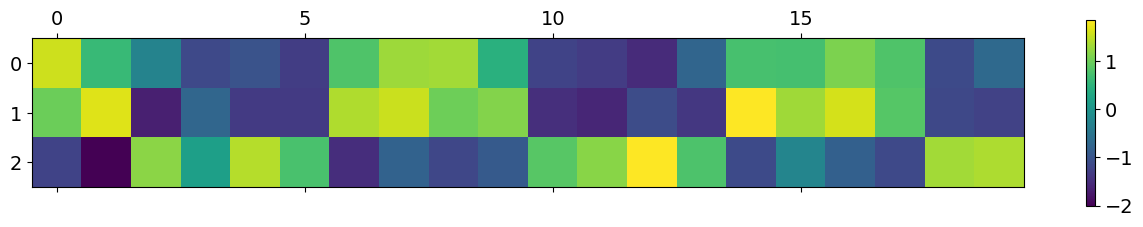

100
99 	 ...Done!
0.1 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

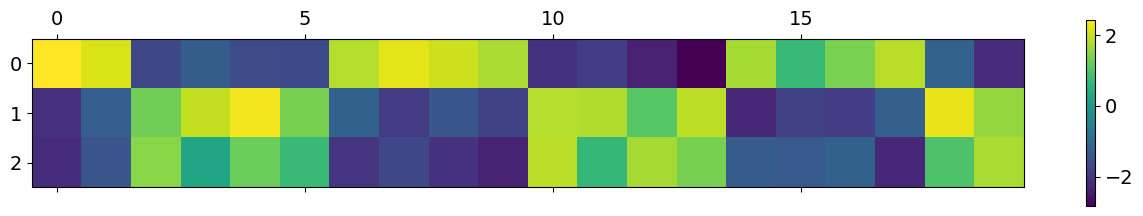

100
99 	 ...Done!
0.15 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

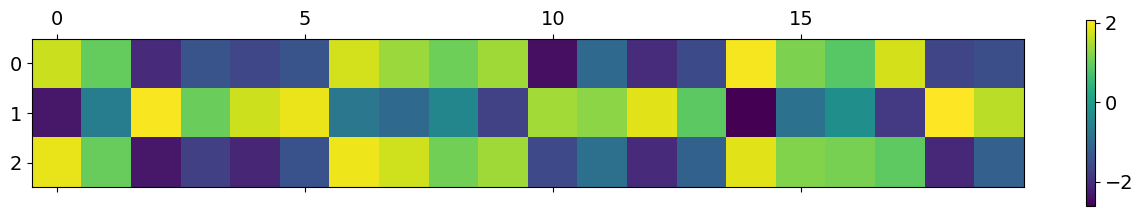

100
99 	 ...Done!
0.2 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

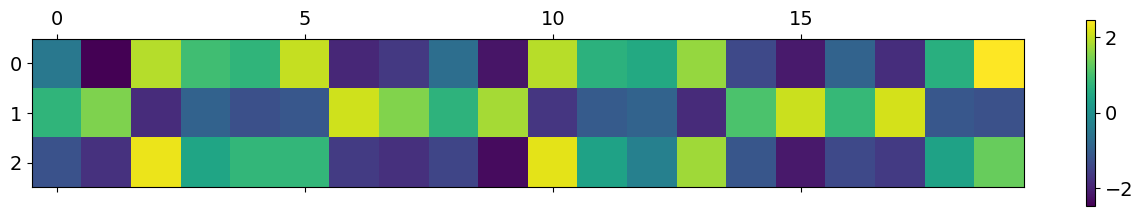

100
99 	 ...Done!
0.25 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

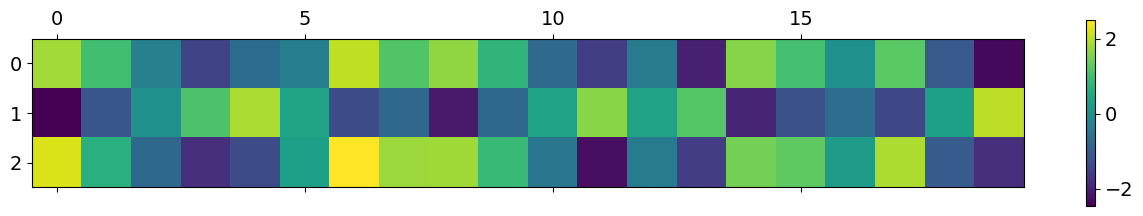

100
99 	 ...Done!
0.3 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

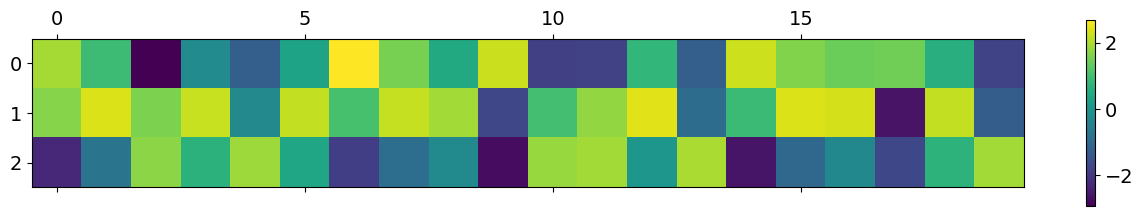

100
99 	 ...Done!
0.35 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

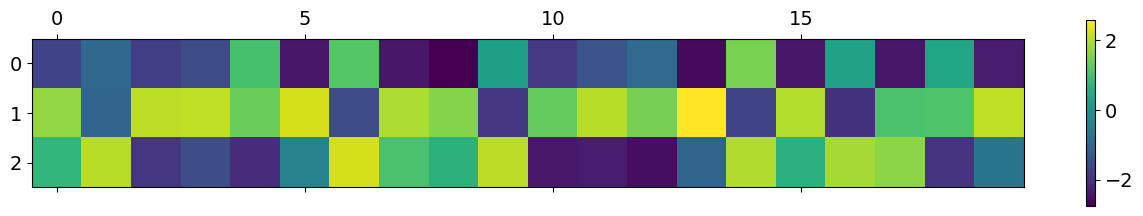

100
99 	 ...Done!
0.4 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

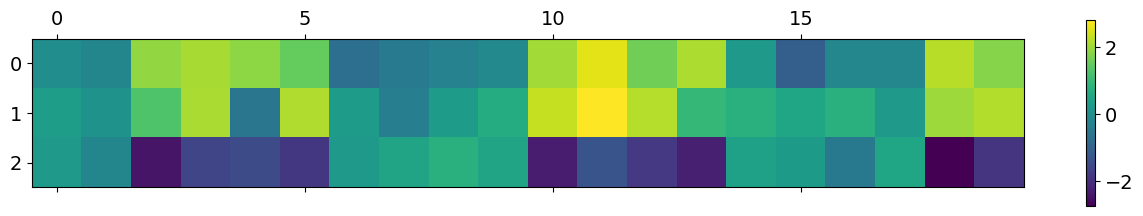

100
99 	 ...Done!
0.45 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

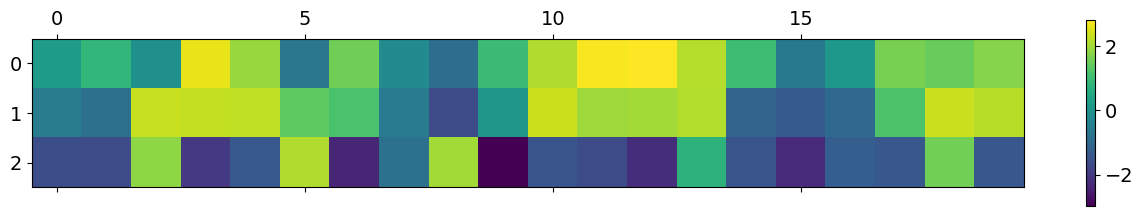

100
99 	 ...Done!
0.5 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

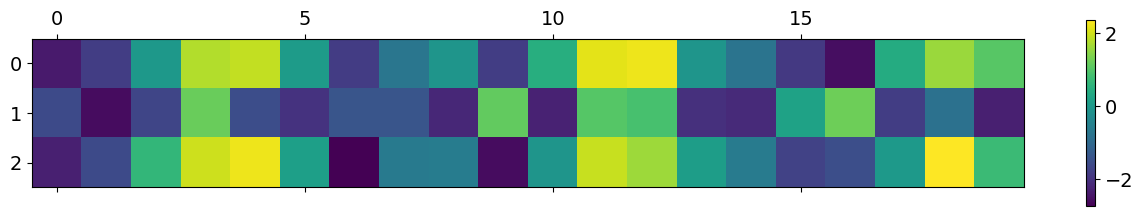

100
99 	 ...Done!


In [12]:
# random seed for reproducibility
np.random.seed(seed)

# learning rate
l_rate = 1e-3

# minibatch
mini_batch = 500

#Loglikelihood
Loglikelihood = np.zeros((len(amp_list), n_epochs))

# train model
print('===================================================')
for i, amp in enumerate(amp_list):
    
    rbm = boltzmanmachine(L,M,sigma,vmin=vmin, spin=spin)
    print(amp, end=' ')
    for epoch in range(n_epochs):
        # aggregate normalization of batch statistics and learning rate
        for k in range(N):
            rbm.train(data=v[k],
                      learning_rate=l_rate,
                      batch_size=mini_batch,
                      n_contrastive_div=cdn,
                      Amp_training=amp,
                      Algorithm=Algorithm)
        
        #Loglikelihood
        Loglikelihood[i, epoch] = Log(rbm.w, rbm.a, rbm.b)

        # randomize the order of input data
        np.random.shuffle(v)
        if epoch==n_epochs-1:
            plt.matshow(rbm.w.T)
            plt.colorbar()
            plt.show()
            print(epoch+1)
        print(epoch, end='')
    
    if spin:
        file_name='Models/'+str(Algorithm)+'_'+str(amp).replace('.','')+'_'+str(cdn)+'_spin'+'.npz'
    else:
        file_name='Models/'+str(Algorithm)+'_'+str(amp).replace('.','')+'_'+str(cdn)+'.npz'
    rbm.save_model(file_name)

    print(' \t ...Done!')
    

## Loglikelihood results
The Loglikelihod is plotted as a function of the epochs for every training amplitude.

amp: 0.05
amp: 0.1
amp: 0.15
amp: 0.2
amp: 0.25
amp: 0.3
amp: 0.35
amp: 0.4
amp: 0.45
amp: 0.5


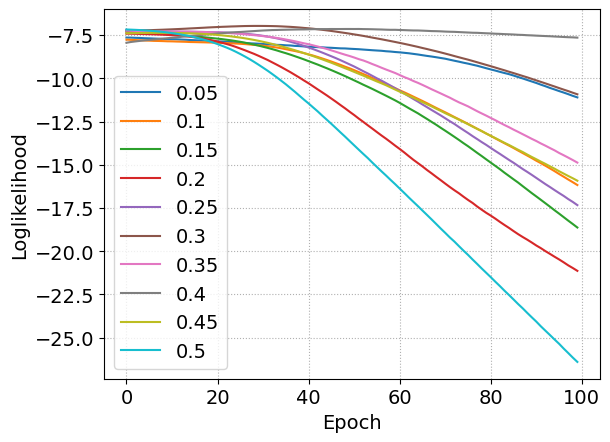

In [14]:
epochs_list = np.arange(n_epochs)
# plt.plot(epochs_list, Loglikelihood)
# plt.xlabel('Epoch')
# plt.ylabel('Loglikelihood')
# plt.grid(linestyle='dotted')
# #plt.legend(loc='lower right')
# plt.show()

for i, amp in enumerate(amp_list):
    print('amp:', amp)
    plt.plot(epochs_list, np.reshape(Loglikelihood, (10,100))[i], label=f'{amp}')

plt.xlabel('Epoch')
plt.ylabel('Loglikelihood')
plt.grid(linestyle='dotted')
plt.legend(loc='lower left')
plt.savefig('Loglikelihood.png')
plt.show()


# Analysis 
In this part, we generate the fantasy particles using generation amplitudes that range from 0.05 to 0.5. In order to evaluate the perfomance of our Boltzman machine trained at different temperatures we introduce the Jensesn-Shannon (JS) divergence as a metric. We plot the heatmaps of the JS divergence to chose the best combiantion amplitudes.

### Create a list with the file names containing the trained models

In [11]:
if spin:

    models = ['Models/RMSprop_005_1_spin.npz',
                  'Models/RMSprop_01_1_spin.npz',
                  'Models/RMSprop_015_1_spin.npz',
                  'Models/RMSprop_02_1_spin.npz',
                  'Models/RMSprop_025_1_spin.npz',
                  'Models/RMSprop_03_1_spin.npz',
                  'Models/RMSprop_035_1_spin.npz',
                  'Models/RMSprop_04_1_spin.npz',
                  'Models/RMSprop_045_1_spin.npz',
                  'Models/RMSprop_05_1_spin.npz']
    vmin= -1

else:
    models = ['Models/RMSprop_005_1.npz',
                  'Models/RMSprop_01_1.npz',
                  'Models/RMSprop_015_1.npz',
                  'Models/RMSprop_02_1.npz',
                  'Models/RMSprop_025_1.npz',
                  'Models/RMSprop_03_1.npz',
                  'Models/RMSprop_035_1.npz',
                  'Models/RMSprop_04_1.npz',
                  'Models/RMSprop_045_1.npz',
                  'Models/RMSprop_05_1.npz']
    vmin=0

amp_list = [0.05, 0.10, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

## PDF 
Probability distribution function of the possible proteins obtanable from the one-hot encoding representation of the 5 amminoacids.  

In [8]:
def convert_to_decimal_protein(v):
    '''
    Convert the raw protein list of strings of 1s and 0s 
    to binary numbers
    '''
    protein_list = np.copy(v).astype(str)
    proteins_dataset = np.zeros(protein_list.shape[0]).astype(int)

    for k in np.arange(protein_list.shape[0]):
        proteins_dataset[k] = int(''.join(protein_list[k]),2)
        
    return list(proteins_dataset)

def return_protein_probabilities(decimal_proteins_list, n_amminoacids=5):
    '''
    Returns a pdf. Each element of the returned vector
    represents the probability of each one of the 4^5 proteins
    in the list passed to the function.
    
    The output vector length is always 4^5=1024, independently of
    the input proteins list passed as input.
    '''
    #number of amminoacids in the protein
    n_ammino=n_amminoacids
    
    #total number of preteins, to normalize the pdf
    n_proteins=len(decimal_proteins_list)

    #encoding of amminoacids
    v1,v2,v3,v4=np.eye(4)

    #list all possible combinations of proteins
    possibilities=list(itertools.product(['1000','0100','0010','0001'],
                                         repeat=n_ammino))

    #converts proteins to decimal representation
    decimal=list()
    for p in possibilities:
        decimal.append(int(''.join(p),2))

    #sort the representation from bigger to smaller values
    decimal.sort(reverse=True)

    #initialize a dict with proteins as keys
    protein_cnt=dict.fromkeys(decimal,0)

    #counts the number of times the protein was found
    for protein in decimal_proteins_list:
        protein_cnt[protein]+=1 

    #return the ordered list of 
    #normalized probabilities for each possible protein
    norm_prob=np.array(list(protein_cnt.values()))/n_proteins
    
    return norm_prob


## Computing the empirical probability distribution of our data

In [9]:
proteins_dataset0=convert_to_decimal_protein(v0)
Q=return_protein_probabilities(proteins_dataset0)

print('Len protein dataset: ',len(proteins_dataset0))
print('Len p_dataset: ', len(Q))
print('Norm p_dataset: ', Q.sum())

Len protein dataset:  10000
Len p_dataset:  1024
Norm p_dataset:  1.0


## Importing the JS divergence 
The JS divergence is used to compute the distance between the probability distributions of the data and the fantasy particles obtained for each training and generation amplitudes.

In [10]:
from scipy.spatial.distance import jensenshannon

## Computing the Jensen-Shannon divergence for different training and generetion amplitude 

In [19]:
js_values = np.zeros((len(models), len(models)))

In [20]:
for i, model in enumerate(models):
    print(f'{model}:', end='\t')
    for k, amp in enumerate(amp_list):

        np.random.seed(seed)
        rbm = boltzmanmachine(L,M,sigma, vmin=vmin, spin=spin)
        rbm.load_model(model)
        
        vf = rbm.gen_fantasy(v, amp)
        vf = ((vf+1)/2).astype(int)
              
        proteins_dataset=convert_to_decimal_protein(vf)
        p_dataset=return_protein_probabilities(proteins_dataset)
        js_values[i,k] = jensenshannon(p_dataset, Q)
         
        print('.', end='')
    print( ' done')

Models/RMSprop_005_1_spin.npz:	.......... done
Models/RMSprop_01_1_spin.npz:	.......... done
Models/RMSprop_015_1_spin.npz:	.......... done
Models/RMSprop_02_1_spin.npz:	.......... done
Models/RMSprop_025_1_spin.npz:	.......... done
Models/RMSprop_03_1_spin.npz:	.......... done
Models/RMSprop_035_1_spin.npz:	.......... done
Models/RMSprop_04_1_spin.npz:	.......... done
Models/RMSprop_045_1_spin.npz:	.......... done
Models/RMSprop_05_1_spin.npz:	.......... done


### Storing Jensen-Shannon divergence values 

In [21]:
if spin:
    s='_spin'
else:
    s=''
np.savez('Models/Metrics'+s+'.npz', js=js_values)

## Plot the heatmap for the JS divergence

In [23]:
import seaborn as sns

In [25]:
heatmap_nospin = np.load('Models/Metrics.npz')
heatmap_spin = np.load('Models/Metrics_spin.npz')
    
js_nospin = heatmap_nospin['js']
js_spin = heatmap_spin['js']

df_nospin = pd.DataFrame(js_nospin, columns=amp_list, index=amp_list)
df_spin = pd.DataFrame(js_spin, columns=amp_list, index=amp_list)

[]

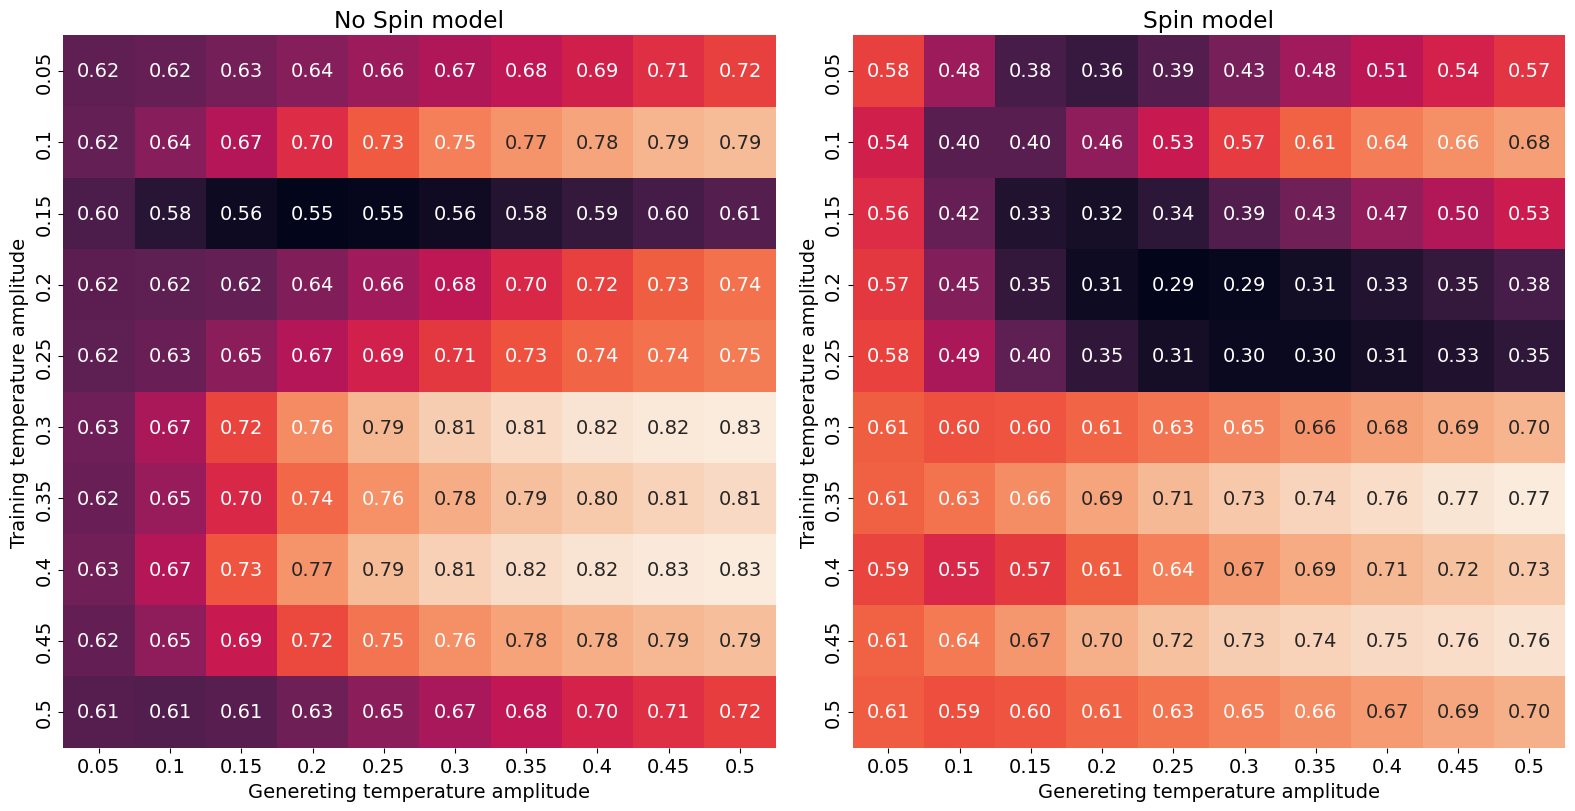

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,16))
fig.tight_layout()
sns.heatmap(ax=ax[0],data=df_nospin,annot=True,fmt=".2f",cbar=False,square=True)
sns.heatmap(ax=ax[1],data=df_spin,annot=True,fmt=".2f",cbar=False,square=True)


ax[0].set_title('No Spin model')
ax[0].set_ylabel('Training temperature amplitude')
ax[0].set_xlabel('Genereting temperature amplitude')


ax[1].set_title('Spin model')
ax[1].set_ylabel('Training temperature amplitude')
ax[1].set_xlabel('Genereting temperature amplitude')

plt.savefig('JSheatmaps.png')
plt.plot()

# Best model 
As best model we choose the one with the lowest JS divergens value.

# Hidden variables' weights
We plot the weights $w_{i\mu}$ of each hidden unit $\mu$ for the best model in an A×G table, with a color map preserving the rule that red means positive and blue means negative weight. A=4 is the number of type of amminoacid allowed in the one-hot encoding. G=5 is number of amminoacid for each protein. Since our best model is obtained in the spin representaion.

## Load model weigths to plot

In [12]:
file_name='Models/RMSprop_02_1_spin.npz' # the best training so far

model = np.load(file_name)        
w = model['w']
a = model['a']
b = model['b']

n_ammino = 5
n_sub_ammino = 4
n_hidden = M 

## One hot encoding

In [22]:
v=np.eye(4)

if spin: 
    v=v*2-1

v1,v2,v3,v4=v[:]
print('v1: ',v2, v1.shape)

v1:  [-1.  1. -1. -1.] (4,)


## Weights of the best model

In [23]:
w[:,0] # first hidden unit weigths

array([-0.50794003, -2.46833904,  1.90636577,  0.935339  ,  0.74109098,
        2.02179539, -1.92201854, -1.64921711, -0.7016155 , -2.18057745,
        1.91618783,  0.69499215,  0.50941615,  1.66895804, -1.38964135,
       -2.11450211, -0.90286546, -1.81822539,  0.62386214,  2.44773917])

In [24]:
ww=w.reshape((n_ammino,n_sub_ammino, n_hidden)) #reshaped: one matrix for each hidden l, one row for each site,
np.dot(ww[:,:,0], v1) # compute per site contribution of each 4 amminoacids types for hidden l=0

array([-0.88130576,  2.29053123, -1.13221802,  2.34460157, -2.15624137])

In [25]:
output=np.zeros((4,5,n_hidden))
output_vv=np.zeros((4,5,n_hidden))


for h in range(n_hidden):
    output[:,:,h]=np.array([np.dot(ww[:,:,h], v1),
                     np.dot(ww[:,:,h], v2),
                     np.dot(ww[:,:,h], v3),
                     np.dot(ww[:,:,h], v4)])

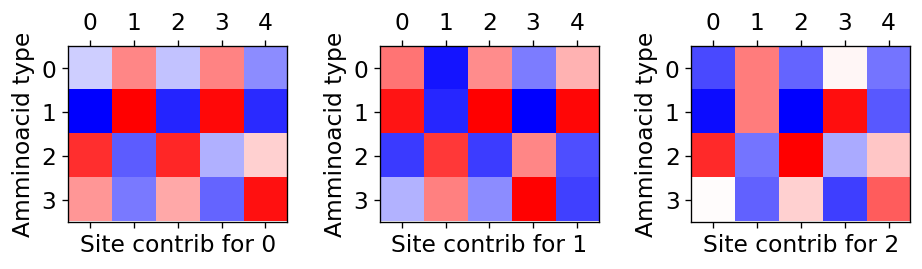

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=n_hidden, figsize=(8,4), dpi=120)
fig.tight_layout()

for h in range(n_hidden):
    ax[h].matshow(output[:,:,h], cmap='bwr')
    ax[h].set_xlabel('Site contrib for '+str(h))
    ax[h].set_ylabel('Amminoacid type')
    
#     ax[h//3][h%3].matshow(output[:,:,h], cmap='bwr')
#     ax[h//3][h%3].set_xlabel('Site contrib for '+str(h))
#     ax[h//3][h%3].set_ylabel('Amminoacid type')

# Contrastive Divergence 
We tune the hyperparameter that controls the contrastive divergence algorithm in order to try to improve the best model obtained from the last section.

### Defining CD parameter

In [28]:
cdn  = [2,3]        #set the number of phases
amp_training = 0.2  #amp of the best model

### Initialize the Restricted Boltzmann Machine

0.2 01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

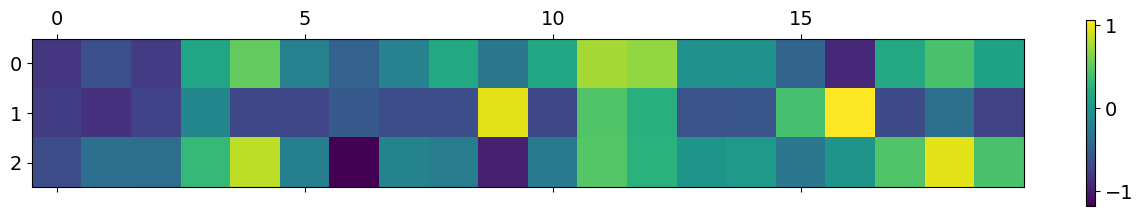

99 	 ...Done!
01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

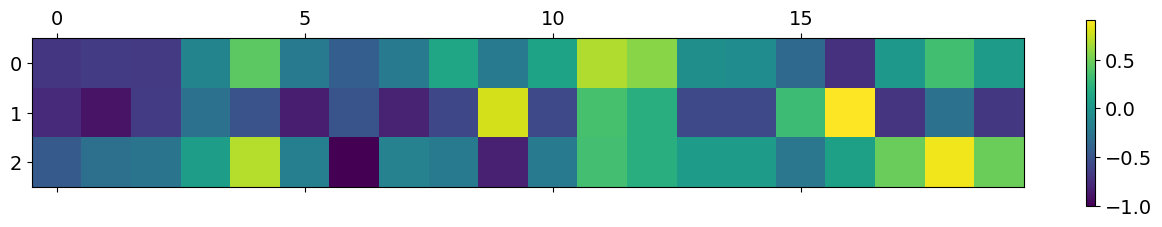

99 	 ...Done!


In [28]:
# random seed for reproducibility
np.random.seed(seed)

# learning rate
l_rate = 1e-3

# minibatch
mini_batch = 500

# train model
print('===================================================')
print(amp_training, end=' ')
for cd in cdn:
    for epoch in range(n_epochs):
        # aggregate normalization of batch statistics and learning rate
        for k in range(N):
            rbm.train(data=v[k],
                      learning_rate=l_rate,
                      batch_size=mini_batch,
                      n_contrastive_div=cd,
                      Amp_training=amp_training,
                      Algorithm=Algorithm)

        # randomize the order of input data
        np.random.shuffle(v)
        if epoch==n_epochs-1:
            plt.matshow(rbm.w.T)
            plt.colorbar()
            plt.show()

        print(epoch, end='')

    if spin:
        file_name='Models/'+str(Algorithm)+'_'+str(amp_training).replace('.','')+'_'+str(cd)+'_spin'+'.npz'
    else:
        file_name='Models/'+str(Algorithm)+'_'+str(amp_training).replace('.','')+'_'+str(cd)+'.npz'
    rbm.save_model(file_name)

    print(' \t ...Done!')


### Checking for improvments with contrastive divergence implementation

In [29]:
np.random.seed(seed)
rbm_nospin = boltzmanmachine(L,M,sigma, vmin=0., spin=False)
rbm_nospin.load_model('Models/RMSprop_02_2_spin.npz')

vf = rbm_nospin.gen_fantasy(v, 0.2)
vf = ((vf+1)/2).astype(int)

proteins_dataset=convert_to_decimal_protein(vf)
p_dataset=return_protein_probabilities(proteins_dataset)
print(jensenshannon(p_dataset, Q))

ValueError: shapes (4,) and (20,3) not aligned: 4 (dim 0) != 20 (dim 0)

In [30]:
np.random.seed(seed)
rbm_spin = boltzmanmachine(L,M,sigma, vmin=-1, spin=True)
rbm_spin.load_model('Models/RMSprop_02_2_spin.npz')

vf = rbm_spin.gen_fantasy(v, 0.2)
vf = ((vf+1)/2).astype(int)

proteins_dataset=convert_to_decimal_protein(vf)
p_dataset=return_protein_probabilities(proteins_dataset)
print(jensenshannon(p_dataset, Q))

0.7773067095857109
